# Introducción al trabajo

Se parte de una base de datos con 4 clases, tres de ellas correspondientes a cancer y una sin cancer. El problema es de clalsificación y se ha dividido en dos subproblemas. Por un lado se pretende clasificar si un paciente tiene o no cancer, pasando a un problmema de clasificación binaria con dos clases. Por otro, bajo el supuesto de que un paciente tiene cáncer, clasificar qué tipo de cáncer es el que tiene dentro de las tres posibilidades obteniendo así un problema de clasificación multiclase. Este fichero se corresponde a la clasificación multiclase. 



La base de datos se encuentra en el siguiente enlace : https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri

Los archivos binarios en la consigna UGR: https://consigna.ugr.es/f/VEz4Wl8FwW22QLh2/Binario.zip

El código puede ser ejecutado usando los binarios o directamente descargando la base de datos. En ambos casos siga las instrucciones del apartado __Lectura de Datos y Preprocesado.__  

Muchas funciones auxiliares tales como la lectura de los datos, algunas funciones de visualización y de preprocesado vienen programadas en el fichero llamado utilidades.py  

Cada vez que se realice la ejecución de un modelo se recomienda reiniciar el entorno de ejecución de Google Colab debido a la gran ocupación de memoria RAM que éstos producen.

Carga de Google Colab

In [ ]:
from google.colab import drive 
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
cd './drive/MyDrive/Colab Notebooks/Proyecto'

/content/drive/.shortcut-targets-by-id/1sY20LclC8q7CIMpnOFT3SfYm3hMOB994/Proyecto


In [ ]:
ls

 au_BinaryClasification/               ModeloSimple2MC.csv
 Binarios/                             ModeloSimpleMC.csv
 BinaryClassification.ipynb            ModeloVGGMC.csv
 Ensemble1.csv                         model_plot.png
 Ensemble2.csv                        'Multiclass Clasification.ipynb'
 Ensemble3.csv                        'Paquito el Chocolatero.ipynb'
 laboratiorio_pilar.ipynb              __pycache__/
 Laboratorio                           Test_Ensemble.csv
'Laboratorio Multiclase.ipynb'         Test_FT_Ensemble.csv
 LaboratorioSilvia21Enero.ipynb        Test_FT_Inception.csv
 LaboratorioSilvia2.ipynb              Test_Incep_MC.csv
 LaboratorioSilvia3_LECTURA2P2.ipynb   Testing/
 LaboratorioSilvia.ipynb               Test_m2_binary.csv
 Modelo2_FT.csv                        Test_mIncep_binary.csv
 ModeloEnsemble_FT.csv                 Test_Modelo2_MC.csv
 ModeloInception_FT.csv                Training/
 ModeloInceptionMC.csv                 utilidades.py


Cargamos librerías

In [ ]:
import numpy as np 
import pandas as pd
from tensorflow import keras
import tensorflow as tf
from utilidades import *
import cv2
import imutils

from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD

from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D,BatchNormalization, Average
from tensorflow.keras import models, layers, Input
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import concatenate

Si usamos GPU ejecutar las siguientes celdas

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
sess = tf.compat.v1.Session(config=config)

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.is_gpu_available())
print(tf.test.is_built_with_cuda())

Num GPUs Available:  1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
True


# Lectura de datos
 

## Lectura usando los archivos binarios.

Si desea leer los datos directamente usando los binarios y evitar así todos los procesos de lectura de imágenes y preprocesado solo tiene que cerciorarse de que los archivos se encuentren en la ruta de la variable _directorio_ de más abajo y ejecutarla. Tras ello, ir a la siguiente sección

In [ ]:
directorio = 'Binarios/CM/'

training_labels = np.load(directorio + 'train_labels.npy')
training_set = np.load(directorio + 'train_images.npy')
test_set = np.load(directorio + 'test_images.npy')
test_labels = np.load(directorio + 'test_labels.npy')

## Lectura de datos usando las imágenes propias de la Base de Datos

En caso de no tener los binarios, ejecutar las siguientes celdas:

In [ ]:
TRAIN_DIR = './Training/'
TEST_DIR = './Testing/'
IMG_SIZE = (224,224)

Cargamos los datos

In [ ]:
X_train, y_train,  training_labels = carga_datos_openCV(TRAIN_DIR)
X_test, y_test, test_labels        = carga_datos_openCV(TEST_DIR)

100%|██████████| 4/4 [00:40<00:00, 10.20s/it]
/content/drive/.shortcut-targets-by-id/1sY20LclC8q7CIMpnOFT3SfYm3hMOB994/Proyecto/utilidades.py:106: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X = np.array(X)


2878 imágenes cargadas de la ruta ./Training/.


100%|██████████| 4/4 [00:21<00:00,  5.39s/it]

403 imágenes cargadas de la ruta ./Testing/.


Nos quedamos con las clases con cáncer, por lo que se eliminará la clase 2 (no_tumor)

In [ ]:
# Obtenemos los índices para los que la clase es la 2
result = np.where(y_train==2)[0]  

# Eliminamos del conjunto de entrenamiento y test los ejemplos sin cáncer
X_train = np.delete(X_train, result, None)
y_train = np.delete(y_train, result, None)

result = np.where(y_test==2)[0]
X_test = np.delete(X_test, result, None)
y_test = np.delete(y_test, result, None)

# Comprobamos que se ha eliminado correctamente
print(np.where(y_train == 2))
print(np.where(y_test  == 2))

(array([], dtype=int64),)
(array([], dtype=int64),)


Ahora tenemos 3 tipos de clases: 0, 1 y 3. Renombramos la clase 3 a clase 2

In [ ]:
# Obtenemmos los indices para los que la clase vale 3
np.where(y_train==3)  #1648-2483
np.where(y_test==3)   #224-297

# Los reemplazamos por 2 usando slices
y_train[1648:2484] = 2
y_test[224:298] = 2

# Comprobamos que el cambio se ha hecho efectivo
print(np.where(y_train == 3))
print(np.where(y_test  == 3))

(array([], dtype=int64),)
(array([], dtype=int64),)


Categorizamos las etiquetas

In [ ]:
y_train    = to_categorical(y_train,3)
y_test     = to_categorical(y_test,3)

Preprocesamos las imágenes, las recortamos y aplicamos un redimensionamiento y el preprocesado de imageNet. Ambas funciones se encuentran implementadas en el fichero utilidades.py

In [ ]:
X_train_crop = recortar_imagen(X_train)
X_test_crop  = recortar_imagen(X_test)

training_set = preprocess_imgs(X_train_crop, IMG_SIZE)
test_set     = preprocess_imgs(X_test_crop, IMG_SIZE)

/content/drive/.shortcut-targets-by-id/1sY20LclC8q7CIMpnOFT3SfYm3hMOB994/Proyecto/utilidades.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(set_new)


Desordenamos las imágenes

In [ ]:
from random import shuffle,seed
seed(123456)

# Guardamos índices
ind_train = list(range(len(training_set)))
ind_test = list(range(len(test_set)))
# Desordenamos
shuffle(ind_train)
shuffle(ind_test)
# Construimos en base a los índices
training_set       = training_set[ind_train]
y_train            = y_train[ind_train]

test_set           = test_set[ind_test]
y_test             = y_test[ind_test]

training_labels = y_train
test_labels     = y_test

Si se quiere guardar los binarios para no repetir el proceso anterior ejecutar la siguiente celda

In [ ]:
directorio = 'Binarios/CM/'
np.save(directorio + 'train_images.npy', training_set)
np.save(directorio + 'train_labels.npy', training_labels)
np.save(directorio + 'test_images.npy', test_set)
np.save(directorio + 'test_labels.npy', test_labels)

# Funciones Auxiliares

In [ ]:
def import_metric_pandas(model_name,loss,accuracy):
  '''
  Importamos las métricas a un dataFrame de pandas
  - model_name: nombre del modelo -- string
  '''

  # Metemos estas tres métricas pasadas por argumento
  datos = np.asarray([loss,accuracy])
  
  # Nombramos filas y columnas
  columnas = [model_name] 
  filas = ['loss','accuracy']

  # Creamos el datafframe
  df = pd.DataFrame(datos, columns=columnas, index=filas)

  return df

In [ ]:
def validacionCruzada(model, x_train,y_train,num_folds,model_name='Default',verbose=0, show=False):
  '''
    Función que se encarga de realizar el proceso de validación experimental.
    Recibe como parámetro el modelo, los datos de entrenamiento y los número de folds.
  '''
  # Instanciamos Earlingstopping 
  callback=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=early, restore_best_weights=True)]
  metricas = ['accuracy']
  loss_function = keras.losses.categorical_crossentropy

  # Inicializamos stratified-cross-validation
  skf = StratifiedKFold(n_splits = num_folds, shuffle = False) 

  # Compilacion del modelo: especificamos la métrica Accuracy, la función de perdida a entropia cruzada y el optimizador
  model.compile(loss=loss_function, optimizer=opt, metrics = metricas)

  # Guardamos los pesos
  weights=model.get_weights()

  # Vectores que guardan el valor de sus respectivas métricas en cada fold
  vloss = []
  vacc  = []

  foldNum=1

  # Para cada fold
  for train_index, test_index in skf.split(x_train,y_train.argmax(1)):
    print(f'Entrenando el fold {foldNum} ...')

    # Calculo los conjuntos de entrenamiento y test
    X_train_cross, X_test_cross = x_train[train_index], x_train[test_index]
    Y_train_cross, Y_test_cross = y_train[train_index], y_train[test_index]

    # Del conjunto de entrenamiento, tomamos un 10% para validación
    fold_x_train, fold_x_valid, fold_y_train, fold_y_valid = train_test_split(X_train_cross, Y_train_cross, test_size=0.1)
    


    # Entrenamiento: se especifican los conjuntos de train,validación,numero de epocas, EarlyStopping definido anteriormente
    history = model.fit(x = fold_x_train, 
                        y = fold_y_train, 
                        batch_size= batch_size,
                        validation_data = (fold_x_valid, fold_y_valid), 
                        epochs=epochs, 
                        verbose = verbose,
                        callbacks = callback)
      
    # Evaluamos con los datos de test
    scores = model.evaluate(x = X_test_cross, y = Y_test_cross, verbose=verbose)

    # Añadimos métricas
    vloss.append(scores[0])
    vacc.append(scores[1])
    foldNum+=1

    # Reestablecemos los pesos antes del siguiente entrenamiento
    model.set_weights(weights)

    # Visualización
    if show:
      mostrarEvolucion(history)

    print(f'Fold {foldNum} - Numero de epocas realizadas: ', len(history.history['loss']))

  # Convertimos a numpy arrays y hacemos la media
  vloss = np.asarray(vloss)
  vacc  = np.asarray(vacc)
  vloss = vloss.mean()
  vacc  = vacc.mean()

  # Creamos el dataFrame 
  df = import_metric_pandas(model_name,vloss,vacc)

  # Mostramos resultados
  print('------------------------------------------------------------------------')
  print('Resultados obtenidos:')
  print(f'> Loss function: {vloss}')
  print(f'> Accuracy: {vacc}')

  return df

In [ ]:
def fit_evaluate(model,model_name,x_train,y_train,x_test,y_test,verbose=0,show = False):
  """
  Función que entrena al modelo pasado como parámetro y lo evalua.
  Función válida tanto para hacer validación como para evaluar en test.
  """

  # Declaramos early stopping, métricas y función de pérdida
  metricas = ['accuracy']
  loss_function=keras.losses.categorical_crossentropy
  callback=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=early, restore_best_weights=True)]

  # Guardamos los pesos
  weights=model.get_weights()

  # Hacemos una partición para validación 
  x_training, x_valid, y_training, y_valid = train_test_split(x_train, y_train, test_size=0.1)

  # Compilacion del modelo: especificamos la métrica Accuracy, la función de perdida a entropia cruzada y el optimizador
  model.compile(loss=loss_function, optimizer=opt, metrics = metricas)

  # Entrenamos al modelo
  history = model.fit(x = x_training, 
                      y = y_training, 
                      batch_size= batch_size,
                      validation_data = (x_valid, y_valid), 
                      epochs=epochs, 
                      verbose = verbose,
                      callbacks = callback)
  
  # Evaluamos el modelo
  scores = model.evaluate(x = x_test, y = y_test, verbose=verbose)

  # Reestablecemos los pesos antes del siguiente entrenamiento
  model.set_weights(weights)

  # Guardamos métricas
  loss = scores[0]
  accuracy = scores[1]


  # Guardamos los datos en un dataframe
  df = import_metric_pandas(model_name,loss,accuracy)

  # Visualización
  if show == True:
    mostrarEvolucion(history)

  print('Numero de epocas realizadas: ', len(history.history['loss']))

  print('------------------------------------------------------------------------')
  print('Resultados obtenidos:')
  print(f'> Loss function: {scores[0]}')
  print(f'> Accuracy: {scores[1]}')
  
  return df

Declaramos algunas variables globales que usaremos más adelante

In [ ]:
batch_size = 32
epochs = 40
early = 7
opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)

# Modelos

__training_set__: Conjunto de entrenamiento   
__training_labels__: Etiquetas  

__test_set__: Conjunto de test  
__test_labels__: Etiquetas    

## Modelo 1

In [ ]:
##########################################################################################
# MODELO 1
#########################################################################################
def modelo1():

  #Definimos nuestro modelo 
  #-include_top a false porque no vamos a incluir la capa totalmente conectada en la parte superior de la red
  #   Hemos quitado la ultima capa para usar la red como extractor de características !!
  #-weight='imageNet', se entrena la red con ImageNet
  #-pooling='avg' AveragePooling
  #-Como include_top esta a false se debe especificar  input_shape
  model = DenseNet121(weights='imagenet', include_top=False, pooling='avg',input_shape=(224,224,3))

  #Marcamos los pesos como no entrenables para que solo afecte a los pesos de las capas FC
  model.trainable=False

  #Probamos la red DenseNet preentrenada con ImageNet añadiendole una capa dense de 3

  modelSimple= (layers.Dense(3, activation = 'softmax'))(model.output)
  modelSimple=Model(inputs = model.inputs, outputs = modelSimple)
  
  return modelSimple

Entrenando el fold 1 ...
Epoch 1/40
47/47 [==============================] - 27s 354ms/step - loss: 0.5863 - accuracy: 0.5413 - val_loss: 0.4890 - val_accuracy: 0.7169
Epoch 2/40
47/47 [==============================] - 11s 244ms/step - loss: 0.4351 - accuracy: 0.7542 - val_loss: 0.3890 - val_accuracy: 0.8133
Epoch 3/40
47/47 [==============================] - 11s 245ms/step - loss: 0.3720 - accuracy: 0.8019 - val_loss: 0.3379 - val_accuracy: 0.8614
Epoch 4/40
47/47 [==============================] - 11s 245ms/step - loss: 0.3351 - accuracy: 0.8274 - val_loss: 0.3086 - val_accuracy: 0.8614
Epoch 5/40
47/47 [==============================] - 11s 244ms/step - loss: 0.3084 - accuracy: 0.8408 - val_loss: 0.2874 - val_accuracy: 0.8675
Epoch 6/40
47/47 [==============================] - 11s 244ms/step - loss: 0.2902 - accuracy: 0.8489 - val_loss: 0.2731 - val_accuracy: 0.8735
Epoch 7/40
47/47 [==============================] - 11s 243ms/step - loss: 0.2768 - accuracy: 0.8522 - val_loss: 0.26

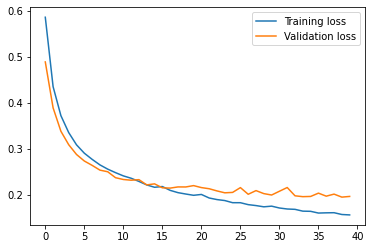

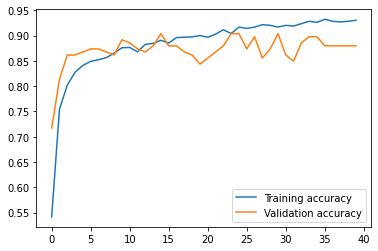

Fold 2 - Numero de epocas realizadas:  40
Entrenando el fold 2 ...
Epoch 1/40
47/47 [==============================] - 12s 251ms/step - loss: 0.5198 - accuracy: 0.6360 - val_loss: 0.4229 - val_accuracy: 0.7169
Epoch 2/40
47/47 [==============================] - 11s 243ms/step - loss: 0.3534 - accuracy: 0.8093 - val_loss: 0.3508 - val_accuracy: 0.8253
Epoch 3/40
47/47 [==============================] - 11s 245ms/step - loss: 0.3038 - accuracy: 0.8388 - val_loss: 0.3142 - val_accuracy: 0.8253
Epoch 4/40
47/47 [==============================] - 11s 245ms/step - loss: 0.2807 - accuracy: 0.8462 - val_loss: 0.3058 - val_accuracy: 0.8434
Epoch 5/40
47/47 [==============================] - 11s 244ms/step - loss: 0.2657 - accuracy: 0.8643 - val_loss: 0.2893 - val_accuracy: 0.8373
Epoch 6/40
47/47 [==============================] - 11s 243ms/step - loss: 0.2497 - accuracy: 0.8737 - val_loss: 0.2820 - val_accuracy: 0.8434
Epoch 7/40
47/47 [==============================] - 11s 243ms/step - loss: 

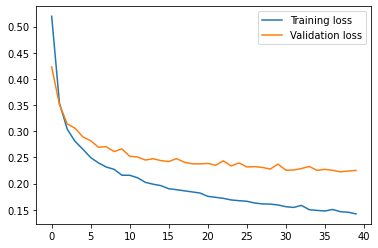

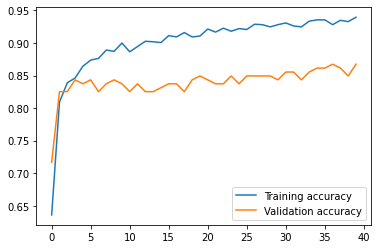

Fold 3 - Numero de epocas realizadas:  40
Entrenando el fold 3 ...
Epoch 1/40
47/47 [==============================] - 13s 281ms/step - loss: 0.5375 - accuracy: 0.6007 - val_loss: 0.3820 - val_accuracy: 0.8072
Epoch 2/40
47/47 [==============================] - 11s 244ms/step - loss: 0.3643 - accuracy: 0.7926 - val_loss: 0.3190 - val_accuracy: 0.8313
Epoch 3/40
47/47 [==============================] - 11s 244ms/step - loss: 0.3192 - accuracy: 0.8235 - val_loss: 0.2852 - val_accuracy: 0.8253
Epoch 4/40
47/47 [==============================] - 11s 243ms/step - loss: 0.2908 - accuracy: 0.8450 - val_loss: 0.2794 - val_accuracy: 0.8675
Epoch 5/40
47/47 [==============================] - 11s 245ms/step - loss: 0.2712 - accuracy: 0.8550 - val_loss: 0.2601 - val_accuracy: 0.8795
Epoch 6/40
47/47 [==============================] - 11s 244ms/step - loss: 0.2606 - accuracy: 0.8631 - val_loss: 0.2493 - val_accuracy: 0.8795
Epoch 7/40
47/47 [==============================] - 11s 244ms/step - loss: 

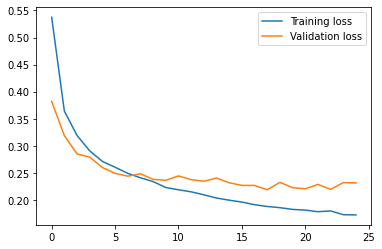

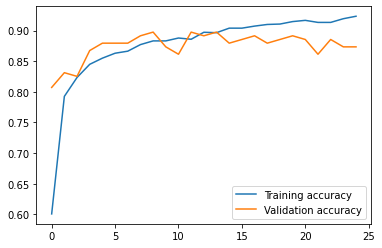

Fold 4 - Numero de epocas realizadas:  25
------------------------------------------------------------------------
Resultados obtenidos:
> Loss function: 0.224440798163414
> Accuracy: 0.8675002455711365


In [ ]:
modelSimple=modelo1()
df_modelo_simple_mc=validacionCruzada(model = modelSimple, x_train = training_set, y_train = training_labels, num_folds = 3, model_name='Modelo 1 MC',verbose=1, show=True)

In [ ]:
#df_modelo_simple_mc.to_csv('ModeloSimpleMC.csv')

In [ ]:
df_modelo_simple_mc

,Modelo 1 MC
loss,0.224441
accuracy,0.867500


## Modelo 2

In [ ]:
#################################################################################################
# MODELO 2: https://link.springer.com/chapter/10.1007/978-981-16-2008-9_1
#################################################################################################
def modelo2():
  model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))

  #Marcamos los pesos como no entrenables para que solo afecte a los pesos de las capas FC
  model.trainable=False
  
  #Probamos la red DenseNet preentrenada con ImageNet añadiendole una capa dense de 3
  modelSimple= (layers.Flatten())(model.output)
  modelSimple= (layers.Dense(1024, activation = 'relu'))(modelSimple)
  modelSimple= (layers.BatchNormalization())(modelSimple)
  modelSimple= (layers.Dropout(0.4))(modelSimple) 
  modelSimple= (layers.Dense(512, activation = 'relu'))(modelSimple)
  modelSimple= (layers.BatchNormalization())(modelSimple)
  modelSimple= (layers.Dropout(0.5))(modelSimple)
  modelSimple= (layers.Dense(3, activation = 'softmax'))(modelSimple)

  model=Model(inputs = model.inputs, outputs = modelSimple)

  return model

In [ ]:
model=modelo2()
df_modelo2_mc = validacionCruzada(model = model, x_train = training_set, y_train = training_labels, num_folds = 3, model_name='Modelo 2 MC',verbose=1, show=True)

In [ ]:
#df_modelo2_mc.to_csv('ModeloSimple2MC.csv')

In [ ]:
df_modelo2_mc

,Modelo 2 MC
loss,0.176662
accuracy,0.907371


## Modelo 3

In [ ]:
#################################################################################################
# MODELO 3: AÑADIR UN BLOQUE VGG https://machinelearningmastery-com.translate.goog/how-to-implement-major-architecture-innovations-for-convolutional-neural-networks/?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es&_x_tr_pto=sc
################################################


def vgg_block(layer_in, n_filters, n_conv):

	for _ in range(n_conv):
		layer_in = Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)

	layer_in = MaxPooling2D((2,2), strides=(2,2))(layer_in)
	return layer_in    
               
def modelo_vgg():
  model = DenseNet121(weights='imagenet', include_top=False,input_shape=(224,224,3))

  #Marcamos los pesos como no entrenables para que solo afecte a los pesos de las capas FC
  model.trainable=False

  #Añadimos el bloque VGG y a continuación la FC
  modelSimple= vgg_block(model.output,64,2)
  modelSimple= (layers.Flatten())(modelSimple)
  modelSimple= (layers.BatchNormalization())(modelSimple)
  modelSimple= (layers.Dropout(0.5))(modelSimple)
  modelSimple= (layers.Dense(3, activation = 'softmax'))(modelSimple)

  modelModel(inputs = model.inputs, outputs = modelSimple)
  
  return model

Entrenando el fold 1 ...
Epoch 1/40
47/47 [==============================] - 23s 311ms/step - loss: 0.4184 - accuracy: 0.7576 - val_loss: 5.6676 - val_accuracy: 0.5904
Epoch 2/40
47/47 [==============================] - 12s 253ms/step - loss: 0.2447 - accuracy: 0.8657 - val_loss: 0.4712 - val_accuracy: 0.7470
Epoch 3/40
47/47 [==============================] - 12s 253ms/step - loss: 0.2164 - accuracy: 0.8858 - val_loss: 0.3661 - val_accuracy: 0.8072
Epoch 4/40
47/47 [==============================] - 12s 249ms/step - loss: 0.1716 - accuracy: 0.9221 - val_loss: 1.0699 - val_accuracy: 0.6446
Epoch 5/40
47/47 [==============================] - 12s 248ms/step - loss: 0.1475 - accuracy: 0.9349 - val_loss: 0.3750 - val_accuracy: 0.7771
Epoch 6/40
47/47 [==============================] - 12s 252ms/step - loss: 0.1089 - accuracy: 0.9516 - val_loss: 0.2318 - val_accuracy: 0.8855
Epoch 7/40
47/47 [==============================] - 12s 249ms/step - loss: 0.0963 - accuracy: 0.9584 - val_loss: 0.71

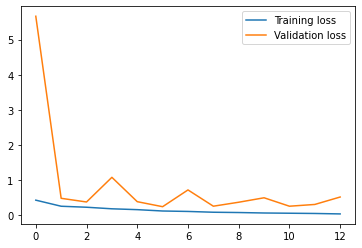

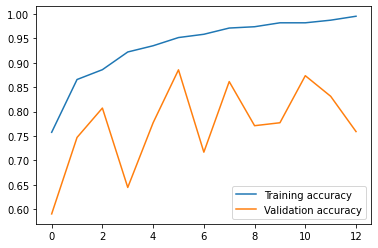

Fold 2 - Numero de epocas realizadas:  13
Entrenando el fold 2 ...
Epoch 1/40
47/47 [==============================] - 12s 260ms/step - loss: 0.4674 - accuracy: 0.7361 - val_loss: 0.6611 - val_accuracy: 0.7952
Epoch 2/40
47/47 [==============================] - 12s 252ms/step - loss: 0.2745 - accuracy: 0.8475 - val_loss: 0.2420 - val_accuracy: 0.8614
Epoch 3/40
47/47 [==============================] - 12s 247ms/step - loss: 0.2148 - accuracy: 0.8892 - val_loss: 0.6490 - val_accuracy: 0.6747
Epoch 4/40
47/47 [==============================] - 12s 247ms/step - loss: 0.1890 - accuracy: 0.9066 - val_loss: 0.2846 - val_accuracy: 0.8434
Epoch 5/40
47/47 [==============================] - 12s 248ms/step - loss: 0.1328 - accuracy: 0.9396 - val_loss: 0.9555 - val_accuracy: 0.6265
Epoch 6/40
47/47 [==============================] - 12s 252ms/step - loss: 0.1224 - accuracy: 0.9449 - val_loss: 0.2403 - val_accuracy: 0.8855
Epoch 7/40
47/47 [==============================] - 12s 248ms/step - loss: 

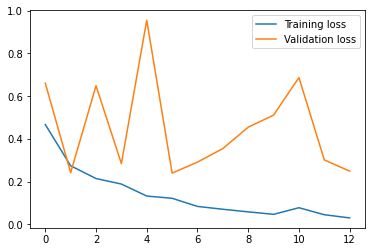

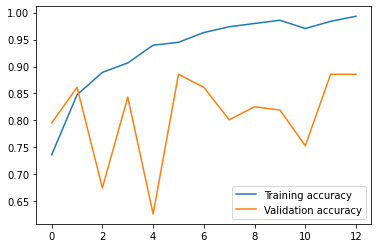

Fold 3 - Numero de epocas realizadas:  13
Entrenando el fold 3 ...
Epoch 1/40
47/47 [==============================] - 12s 263ms/step - loss: 0.4825 - accuracy: 0.7121 - val_loss: 0.4885 - val_accuracy: 0.7651
Epoch 2/40
47/47 [==============================] - 12s 248ms/step - loss: 0.2693 - accuracy: 0.8530 - val_loss: 0.9085 - val_accuracy: 0.6024
Epoch 3/40
47/47 [==============================] - 12s 249ms/step - loss: 0.2033 - accuracy: 0.8919 - val_loss: 0.6487 - val_accuracy: 0.6988
Epoch 4/40
47/47 [==============================] - 12s 248ms/step - loss: 0.1594 - accuracy: 0.9215 - val_loss: 0.8733 - val_accuracy: 0.7530
Epoch 5/40
47/47 [==============================] - 12s 249ms/step - loss: 0.1259 - accuracy: 0.9490 - val_loss: 0.5435 - val_accuracy: 0.7892
Epoch 6/40
47/47 [==============================] - 12s 249ms/step - loss: 0.1099 - accuracy: 0.9584 - val_loss: 0.7255 - val_accuracy: 0.7831
Epoch 7/40
47/47 [==============================] - 12s 254ms/step - loss: 

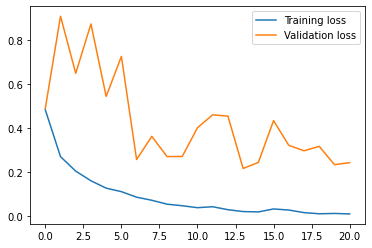

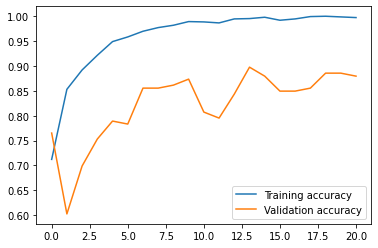

Fold 4 - Numero de epocas realizadas:  21
------------------------------------------------------------------------
Resultados obtenidos:
> Loss function: 0.28343427181243896
> Accuracy: 0.8711326718330383


In [ ]:
modelo=modelo_vgg()
df_vgg_mc=validacionCruzada(model = modelo, x_train = training_set, y_train = training_labels, num_folds = 3, model_name='ModeloVGG MC',verbose=1, show=True)

In [ ]:
#df_vgg_mc.to_csv('ModeloVGGMC.csv')

In [ ]:
df_vgg_mc

,ModeloVGG MC
loss,0.283434
accuracy,0.871133


## Modelo 4

In [ ]:
#################################################################################
 # Modelo 4. Añadir dos bloques INCEPTION  https://machinelearningmastery-com.translate.goog/how-to-implement-major-architecture-innovations-for-convolutional-neural-networks/?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es&_x_tr_pto=sc
 ################################################################################

# Función para crear un modulo Inception
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
	# Convolucion 1x1 
	conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
	# Convolucion 3x3 
	conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
	conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
	# Convolucion 5x5 
	conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
	conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
	# 3x3 max pooling
	pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
	pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
	# Concatenacion de las capas en una capa de salida
	layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
	return layer_out

def modelo_inception():
 
    model = DenseNet121(weights='imagenet', include_top=False,input_shape=(224,224,3))
    model.trainable=False
   
    layer = inception_module(model.output, 64, 96, 128, 16, 32, 32)
   
    layer = inception_module(layer, 128, 128, 192, 32, 96, 64)
    layer = (layers.GlobalAveragePooling2D()) (layer)
    modelSimple= (layers.Dropout(0.4))(layer) 
    modelSimple= (layers.Dense(512, activation = 'relu'))(modelSimple)
    modelSimple= (layers.BatchNormalization())(modelSimple)
    modelSimple= (layers.Dropout(0.5))(modelSimple)
    modelSimple= (layers.Dense(3, activation = 'softmax'))(modelSimple) 

    final_model = Model(inputs=model.inputs, outputs=modelSimple)
    return final_model

Entrenando el fold 1 ...
Epoch 1/40
47/47 [==============================] - 24s 326ms/step - loss: 0.6533 - accuracy: 0.5386 - val_loss: 0.6643 - val_accuracy: 0.5301
Epoch 2/40
47/47 [==============================] - 12s 261ms/step - loss: 0.3990 - accuracy: 0.7233 - val_loss: 0.3602 - val_accuracy: 0.8193
Epoch 3/40
47/47 [==============================] - 12s 262ms/step - loss: 0.2803 - accuracy: 0.8388 - val_loss: 0.2998 - val_accuracy: 0.8313
Epoch 4/40
47/47 [==============================] - 12s 256ms/step - loss: 0.2196 - accuracy: 0.8805 - val_loss: 0.6244 - val_accuracy: 0.6747
Epoch 5/40
47/47 [==============================] - 12s 256ms/step - loss: 0.2026 - accuracy: 0.8899 - val_loss: 0.3000 - val_accuracy: 0.8193
Epoch 6/40
47/47 [==============================] - 12s 262ms/step - loss: 0.1774 - accuracy: 0.8952 - val_loss: 0.2840 - val_accuracy: 0.8253
Epoch 7/40
47/47 [==============================] - 12s 261ms/step - loss: 0.1562 - accuracy: 0.9167 - val_loss: 0.22

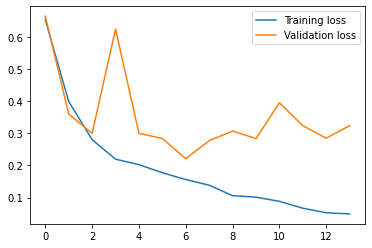

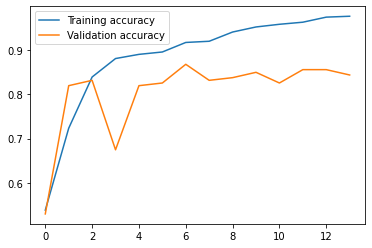

Fold 2 - Numero de epocas realizadas:  14
Entrenando el fold 2 ...
Epoch 1/40
47/47 [==============================] - 13s 268ms/step - loss: 0.6843 - accuracy: 0.5393 - val_loss: 2.3881 - val_accuracy: 0.3072
Epoch 2/40
47/47 [==============================] - 12s 262ms/step - loss: 0.3709 - accuracy: 0.7495 - val_loss: 0.9380 - val_accuracy: 0.6928
Epoch 3/40
47/47 [==============================] - 12s 261ms/step - loss: 0.2522 - accuracy: 0.8583 - val_loss: 0.3717 - val_accuracy: 0.8313
Epoch 4/40
47/47 [==============================] - 12s 257ms/step - loss: 0.2041 - accuracy: 0.8831 - val_loss: 0.5336 - val_accuracy: 0.7349
Epoch 5/40
47/47 [==============================] - 12s 261ms/step - loss: 0.1988 - accuracy: 0.8966 - val_loss: 0.3357 - val_accuracy: 0.8193
Epoch 6/40
47/47 [==============================] - 12s 261ms/step - loss: 0.1437 - accuracy: 0.9234 - val_loss: 0.2718 - val_accuracy: 0.8735
Epoch 7/40
47/47 [==============================] - 12s 256ms/step - loss: 

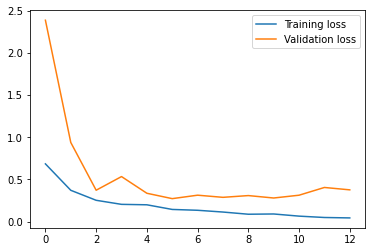

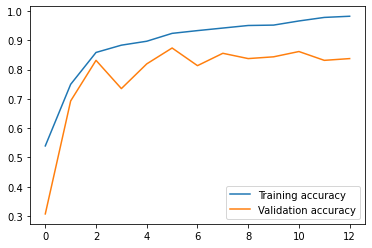

Fold 3 - Numero de epocas realizadas:  13
Entrenando el fold 3 ...
Epoch 1/40
47/47 [==============================] - 13s 275ms/step - loss: 0.7327 - accuracy: 0.4805 - val_loss: 1.2364 - val_accuracy: 0.6145
Epoch 2/40
47/47 [==============================] - 12s 262ms/step - loss: 0.4283 - accuracy: 0.7060 - val_loss: 1.0376 - val_accuracy: 0.4458
Epoch 3/40
47/47 [==============================] - 12s 262ms/step - loss: 0.3146 - accuracy: 0.8228 - val_loss: 0.8767 - val_accuracy: 0.6627
Epoch 4/40
47/47 [==============================] - 12s 262ms/step - loss: 0.3075 - accuracy: 0.8161 - val_loss: 0.2370 - val_accuracy: 0.8675
Epoch 5/40
47/47 [==============================] - 12s 261ms/step - loss: 0.2276 - accuracy: 0.8779 - val_loss: 0.2209 - val_accuracy: 0.8675
Epoch 6/40
47/47 [==============================] - 12s 257ms/step - loss: 0.1987 - accuracy: 0.8866 - val_loss: 0.2601 - val_accuracy: 0.8193
Epoch 7/40
47/47 [==============================] - 12s 262ms/step - loss: 

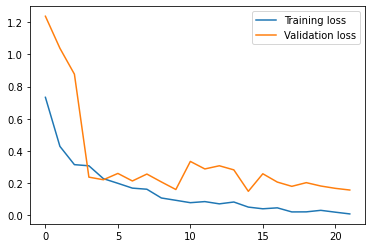

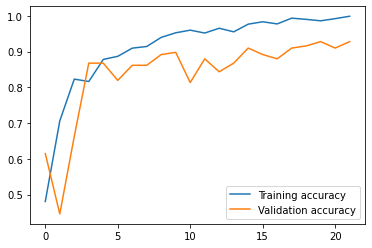

Fold 4 - Numero de epocas realizadas:  22
------------------------------------------------------------------------
Resultados obtenidos:
> Loss function: 0.23600946366786957
> Accuracy: 0.8816006382306417


In [ ]:
modelo=modelo_inception()
df_inception_mc=validacionCruzada(model = modelo, x_train = training_set, y_train = training_labels, num_folds = 3, model_name='ModeloInception MC',verbose=1, show=True)

In [ ]:
#df_inception_mc.to_csv('ModeloInceptionMC.csv')

In [ ]:
df_inception_mc

,ModeloInception MC
loss,0.236009
accuracy,0.881601


## ENSEMBLE

Se crean los respectivos modelos vgg19, densenet121, inception y resnet101 y la función para hacer ensemble. Obviamente cada modelo es adaptado al problema eliminando la última capa fully conected y usando los pesos de imagenet.

Referencias:  

https://stackoverflow.com/questions/49136762/ensemble-resnet50-and-densenet121-in-keras


https://towardsdatascience.com/ensembling-convnets-using-keras-237d429157eb


In [ ]:
from tensorflow.keras.applications import VGG19, InceptionV3, ResNet101

def vgg19(model_input):
    base_model = VGG19(weights='imagenet', include_top=False, input_tensor=model_input)
    last = base_model.output
    base_model.trainable=False
    x = Flatten()(last)
    modelSimple= (layers.Dense(1024, activation = 'relu'))(x)
    modelSimple= (layers.BatchNormalization())(modelSimple)
    modelSimple= (layers.Dropout(0.4))(modelSimple) 
    modelSimple= (layers.Dense(512, activation = 'relu'))(modelSimple)
    modelSimple= (layers.BatchNormalization())(modelSimple)
    modelSimple= (layers.Dropout(0.5))(modelSimple)
    x= (layers.Dense(3, activation = 'softmax'))(modelSimple)
    model = Model(base_model.input, x)
    for layer in model.layers:
      layer._name = layer.name + str("_vgg")
    return model


def densenet121(model_input):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=model_input)
    base_model.trainable=False
    last = base_model.output
    x = Flatten()(last)
    modelSimple= (layers.Dense(1024, activation = 'relu'))(x)
    modelSimple= (layers.BatchNormalization())(modelSimple)
    modelSimple= (layers.Dropout(0.4))(modelSimple) 
    modelSimple= (layers.Dense(512, activation = 'relu'))(modelSimple)
    modelSimple= (layers.BatchNormalization())(modelSimple)
    modelSimple= (layers.Dropout(0.5))(modelSimple)
    x= (layers.Dense(3, activation = 'softmax'))(modelSimple)
    model = Model(base_model.input, x)
    return model

def inception(model_input):
    base_model =InceptionV3(weights='imagenet', include_top=False, input_tensor=model_input)
    last = base_model.output
    base_model.trainable=False
    x = Flatten()(last)
    modelSimple= (layers.Dense(1024, activation = 'relu'))(x)
    modelSimple= (layers.BatchNormalization())(modelSimple)
    modelSimple= (layers.Dropout(0.4))(modelSimple) 
    modelSimple= (layers.Dense(512, activation = 'relu'))(modelSimple)
    modelSimple= (layers.BatchNormalization())(modelSimple)
    modelSimple= (layers.Dropout(0.5))(modelSimple)
    x= (layers.Dense(3, activation = 'softmax'))(modelSimple)
    model = Model(base_model.input, x)
    for layer in model.layers:
      layer._name = layer.name + str("_inception")
    return model

def resnet101(model_input):
    base_model = ResNet101(weights='imagenet', include_top=False, input_tensor=model_input)
    last = base_model.output
    base_model.trainable=False
    x = Flatten()(last)
    modelSimple= (layers.Dense(1024, activation = 'relu'))(x)
    modelSimple= (layers.BatchNormalization())(modelSimple)
    modelSimple= (layers.Dropout(0.4))(modelSimple) 
    modelSimple= (layers.Dense(512, activation = 'relu'))(modelSimple)
    modelSimple= (layers.BatchNormalization())(modelSimple)
    modelSimple= (layers.Dropout(0.5))(modelSimple)
    x= (layers.Dense(3, activation = 'softmax'))(modelSimple)
    model = Model(base_model.input, x)
    for layer in model.layers:
      layer._name = layer.name + str("_resnet")
    return model


def ensemble(models,model_input):
    outputs = [model.outputs[0] for model in models]
    y = Average()(outputs)
    model = Model(model_input,y)
    return model

Declaramos los modelos

In [ ]:
model_input = Input(shape=(224, 224, 3))
vgg19_model = vgg19(model_input)
densenet121_model = densenet121(model_input)
inception_model = inception(model_input)
resnet101_model = resnet101(model_input)

Primer Ensemble: VGG19 y DensetNet121

Entrenando el fold 1 ...
Epoch 1/40
47/47 [==============================] - 71s 925ms/step - loss: 0.3617 - accuracy: 0.7891 - val_loss: 1.3293 - val_accuracy: 0.5904
Epoch 2/40
47/47 [==============================] - 28s 605ms/step - loss: 0.2292 - accuracy: 0.8831 - val_loss: 0.6061 - val_accuracy: 0.7410
Epoch 3/40
47/47 [==============================] - 28s 603ms/step - loss: 0.1335 - accuracy: 0.9328 - val_loss: 0.3478 - val_accuracy: 0.8494
Epoch 4/40
47/47 [==============================] - 28s 601ms/step - loss: 0.0904 - accuracy: 0.9584 - val_loss: 0.2864 - val_accuracy: 0.8795
Epoch 5/40
47/47 [==============================] - 28s 601ms/step - loss: 0.0793 - accuracy: 0.9704 - val_loss: 0.1835 - val_accuracy: 0.8976
Epoch 6/40
47/47 [==============================] - 28s 592ms/step - loss: 0.0773 - accuracy: 0.9745 - val_loss: 0.2482 - val_accuracy: 0.8855
Epoch 7/40
47/47 [==============================] - 28s 592ms/step - loss: 0.0625 - accuracy: 0.9765 - val_loss: 0.31

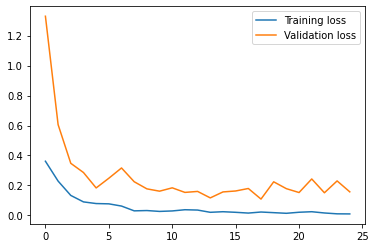

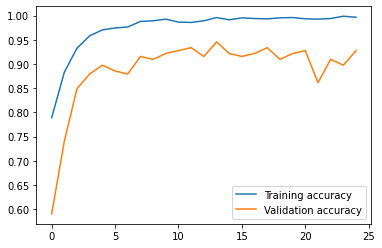

Fold 2 - Numero de epocas realizadas:  25
Entrenando el fold 2 ...
Epoch 1/40
47/47 [==============================] - 29s 627ms/step - loss: 0.4223 - accuracy: 0.7522 - val_loss: 0.5991 - val_accuracy: 0.6807
Epoch 2/40
47/47 [==============================] - 28s 602ms/step - loss: 0.2308 - accuracy: 0.8630 - val_loss: 0.5185 - val_accuracy: 0.8012
Epoch 3/40
47/47 [==============================] - 28s 601ms/step - loss: 0.1686 - accuracy: 0.9167 - val_loss: 0.2226 - val_accuracy: 0.9036
Epoch 4/40
47/47 [==============================] - 28s 592ms/step - loss: 0.1226 - accuracy: 0.9315 - val_loss: 0.2438 - val_accuracy: 0.8976
Epoch 5/40
47/47 [==============================] - 28s 601ms/step - loss: 0.1062 - accuracy: 0.9436 - val_loss: 0.1891 - val_accuracy: 0.8976
Epoch 6/40
47/47 [==============================] - 28s 601ms/step - loss: 0.0951 - accuracy: 0.9496 - val_loss: 0.1493 - val_accuracy: 0.9217
Epoch 7/40
47/47 [==============================] - 28s 591ms/step - loss: 

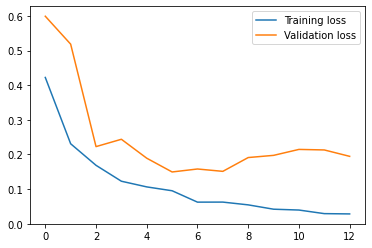

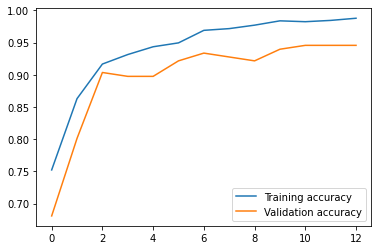

Fold 3 - Numero de epocas realizadas:  13
Entrenando el fold 3 ...
Epoch 1/40
47/47 [==============================] - 37s 782ms/step - loss: 0.4620 - accuracy: 0.7040 - val_loss: 0.8359 - val_accuracy: 0.7048
Epoch 2/40
47/47 [==============================] - 28s 605ms/step - loss: 0.2748 - accuracy: 0.8483 - val_loss: 0.3939 - val_accuracy: 0.8494
Epoch 3/40
47/47 [==============================] - 28s 602ms/step - loss: 0.1837 - accuracy: 0.9067 - val_loss: 0.3371 - val_accuracy: 0.8855
Epoch 4/40
47/47 [==============================] - 28s 602ms/step - loss: 0.1282 - accuracy: 0.9349 - val_loss: 0.2713 - val_accuracy: 0.8855
Epoch 5/40
47/47 [==============================] - 28s 602ms/step - loss: 0.1041 - accuracy: 0.9477 - val_loss: 0.2530 - val_accuracy: 0.9036
Epoch 6/40
47/47 [==============================] - 28s 602ms/step - loss: 0.0743 - accuracy: 0.9658 - val_loss: 0.2058 - val_accuracy: 0.9217
Epoch 7/40
47/47 [==============================] - 28s 592ms/step - loss: 

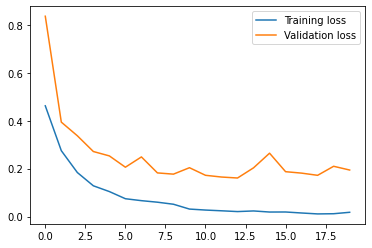

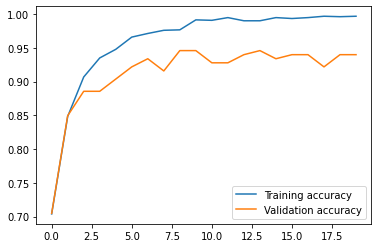

Fold 4 - Numero de epocas realizadas:  20
------------------------------------------------------------------------
Resultados obtenidos:
> Loss function: 0.17604146897792816
> Accuracy: 0.9150256911913554


In [ ]:
ensembled_models = [vgg19_model,densenet121_model]
ensemble_model = ensemble(ensembled_models,model_input)
df_ensemble_1= validacionCruzada(model = ensemble_model, x_train = training_set, y_train = training_labels, num_folds = 3, model_name='Modelo Ensemble VGG19',verbose=1, show=True)

In [ ]:
#df_ensemble_1.to_csv('Ensemble1.csv')

In [ ]:
df_ensemble_1

,Modelo Ensemble VGG19
loss,0.176041
accuracy,0.915026


Segundo ensemble: VGG19, Inception y DenseNet121

Entrenando el fold 1 ...
Epoch 1/40
47/47 [==============================] - 63s 974ms/step - loss: 0.4327 - accuracy: 0.7226 - val_loss: 0.7463 - val_accuracy: 0.5783
Epoch 2/40
47/47 [==============================] - 38s 813ms/step - loss: 0.2689 - accuracy: 0.8496 - val_loss: 0.5412 - val_accuracy: 0.6867
Epoch 3/40
47/47 [==============================] - 38s 810ms/step - loss: 0.2216 - accuracy: 0.8744 - val_loss: 0.4311 - val_accuracy: 0.6988
Epoch 4/40
47/47 [==============================] - 38s 810ms/step - loss: 0.1641 - accuracy: 0.9134 - val_loss: 0.2054 - val_accuracy: 0.8434
Epoch 5/40
47/47 [==============================] - 37s 794ms/step - loss: 0.1286 - accuracy: 0.9375 - val_loss: 0.2066 - val_accuracy: 0.8916
Epoch 6/40
47/47 [==============================] - 38s 810ms/step - loss: 0.1010 - accuracy: 0.9496 - val_loss: 0.1592 - val_accuracy: 0.8976
Epoch 7/40
47/47 [==============================] - 38s 809ms/step - loss: 0.0884 - accuracy: 0.9617 - val_loss: 0.15

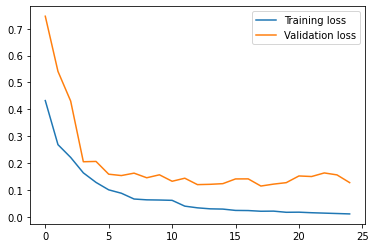

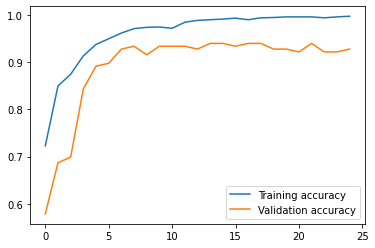

Fold 2 - Numero de epocas realizadas:  25
Entrenando el fold 2 ...
Epoch 1/40
47/47 [==============================] - 39s 840ms/step - loss: 0.3955 - accuracy: 0.7643 - val_loss: 0.7954 - val_accuracy: 0.6627
Epoch 2/40
47/47 [==============================] - 38s 811ms/step - loss: 0.2379 - accuracy: 0.8684 - val_loss: 0.5357 - val_accuracy: 0.7590
Epoch 3/40
47/47 [==============================] - 38s 809ms/step - loss: 0.1748 - accuracy: 0.9006 - val_loss: 0.3118 - val_accuracy: 0.8313
Epoch 4/40
47/47 [==============================] - 38s 818ms/step - loss: 0.1339 - accuracy: 0.9288 - val_loss: 0.3102 - val_accuracy: 0.8253
Epoch 5/40
47/47 [==============================] - 38s 814ms/step - loss: 0.1069 - accuracy: 0.9483 - val_loss: 0.2347 - val_accuracy: 0.8675
Epoch 6/40
47/47 [==============================] - 38s 810ms/step - loss: 0.0806 - accuracy: 0.9671 - val_loss: 0.1835 - val_accuracy: 0.8976
Epoch 7/40
47/47 [==============================] - 38s 811ms/step - loss: 

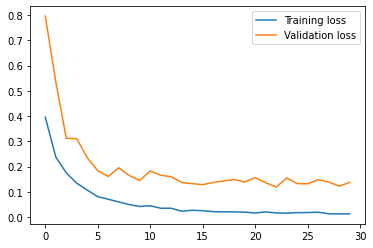

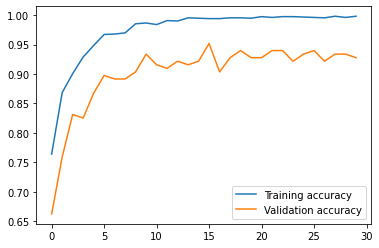

Fold 3 - Numero de epocas realizadas:  30
Entrenando el fold 3 ...
Epoch 1/40
47/47 [==============================] - 41s 882ms/step - loss: 0.4049 - accuracy: 0.7403 - val_loss: 1.4659 - val_accuracy: 0.6265
Epoch 2/40
47/47 [==============================] - 38s 813ms/step - loss: 0.2679 - accuracy: 0.8336 - val_loss: 0.4089 - val_accuracy: 0.7711
Epoch 3/40
47/47 [==============================] - 38s 813ms/step - loss: 0.1931 - accuracy: 0.8919 - val_loss: 0.3071 - val_accuracy: 0.8253
Epoch 4/40
47/47 [==============================] - 38s 815ms/step - loss: 0.1435 - accuracy: 0.9322 - val_loss: 0.2637 - val_accuracy: 0.8494
Epoch 5/40
47/47 [==============================] - 38s 813ms/step - loss: 0.1102 - accuracy: 0.9517 - val_loss: 0.2456 - val_accuracy: 0.8373
Epoch 6/40
47/47 [==============================] - 38s 813ms/step - loss: 0.0915 - accuracy: 0.9624 - val_loss: 0.1925 - val_accuracy: 0.9036
Epoch 7/40
47/47 [==============================] - 39s 830ms/step - loss: 

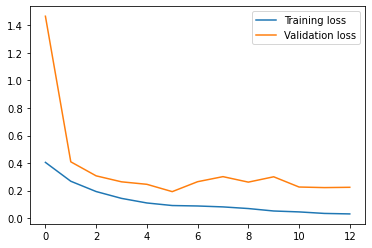

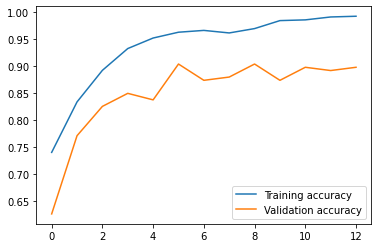

Fold 4 - Numero de epocas realizadas:  13
------------------------------------------------------------------------
Resultados obtenidos:
> Loss function: 0.17154593765735626
> Accuracy: 0.9162300229072571


In [ ]:
ensembled_models = [vgg19_model,inception_model,densenet121_model]
ensemble_model = ensemble(ensembled_models,model_input)
df_ensemble_2= validacionCruzada(model = ensemble_model, x_train = training_set, y_train = training_labels, num_folds = 3, model_name='Modelo Ensemble VGG19 InceptionV3',verbose=1, show=True)

In [ ]:
#df_ensemble_2.to_csv('Ensemble2.csv')

In [ ]:
df_ensemble_2

,Modelo Ensemble VGG19 InceptionV3
loss,0.171546
accuracy,0.916230


Tercer ensemble: ResNet101, VGG19 y DenseNet

In [ ]:
# Ensemble con resnet101
ensembled_models = [resnet101_model,vgg19_model,densenet121_model]
ensemble_model = ensemble(ensembled_models,model_input)

171458560/171446536 [==============================] - 2s 0us/step
Entrenando el fold 1 ...
Epoch 1/40
47/47 [==============================] - 75s 1s/step - loss: 0.4124 - accuracy: 0.7482 - val_loss: 3.4639 - val_accuracy: 0.3916
Epoch 2/40
47/47 [==============================] - 49s 1s/step - loss: 0.2896 - accuracy: 0.8361 - val_loss: 0.5255 - val_accuracy: 0.7229
Epoch 3/40
47/47 [==============================] - 48s 1s/step - loss: 0.2234 - accuracy: 0.8684 - val_loss: 0.3970 - val_accuracy: 0.7892
Epoch 4/40
47/47 [==============================] - 48s 1s/step - loss: 0.1831 - accuracy: 0.9161 - val_loss: 0.3085 - val_accuracy: 0.8434
Epoch 5/40
47/47 [==============================] - 48s 1s/step - loss: 0.1572 - accuracy: 0.9315 - val_loss: 0.2168 - val_accuracy: 0.8976
Epoch 6/40
47/47 [==============================] - 49s 1s/step - loss: 0.1259 - accuracy: 0.9375 - val_loss: 0.2049 - val_accuracy: 0.9096
Epoch 7/40
47/47 [==============================] - 48s 1s/step - lo

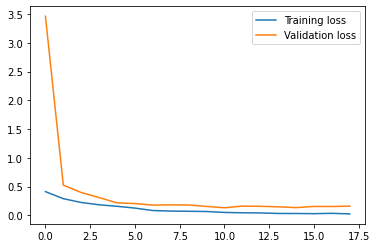

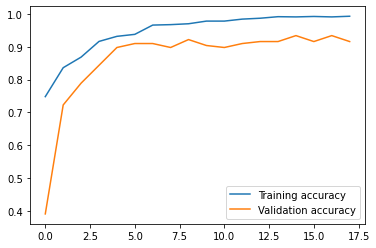

Fold 2 - Numero de epocas realizadas:  18
Entrenando el fold 2 ...
Epoch 1/40
47/47 [==============================] - 50s 1s/step - loss: 0.3956 - accuracy: 0.7441 - val_loss: 1.5340 - val_accuracy: 0.3614
Epoch 2/40
47/47 [==============================] - 49s 1s/step - loss: 0.2506 - accuracy: 0.8623 - val_loss: 0.7675 - val_accuracy: 0.6265
Epoch 3/40
47/47 [==============================] - 49s 1s/step - loss: 0.1938 - accuracy: 0.8999 - val_loss: 0.3254 - val_accuracy: 0.8313
Epoch 4/40
47/47 [==============================] - 49s 1s/step - loss: 0.1465 - accuracy: 0.9255 - val_loss: 0.2545 - val_accuracy: 0.8795
Epoch 5/40
47/47 [==============================] - 49s 1s/step - loss: 0.1253 - accuracy: 0.9436 - val_loss: 0.1724 - val_accuracy: 0.8855
Epoch 6/40
47/47 [==============================] - 48s 1s/step - loss: 0.0920 - accuracy: 0.9543 - val_loss: 0.1792 - val_accuracy: 0.9157
Epoch 7/40
47/47 [==============================] - 49s 1s/step - loss: 0.0776 - accuracy: 0.

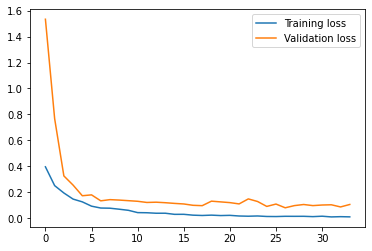

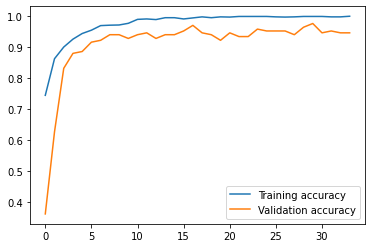

Fold 3 - Numero de epocas realizadas:  34
Entrenando el fold 3 ...
Epoch 1/40
47/47 [==============================] - 52s 1s/step - loss: 0.4020 - accuracy: 0.7497 - val_loss: 0.5752 - val_accuracy: 0.6928
Epoch 2/40
47/47 [==============================] - 49s 1s/step - loss: 0.2695 - accuracy: 0.8409 - val_loss: 0.4508 - val_accuracy: 0.7530
Epoch 3/40
47/47 [==============================] - 49s 1s/step - loss: 0.2062 - accuracy: 0.8933 - val_loss: 0.2424 - val_accuracy: 0.8735
Epoch 4/40
47/47 [==============================] - 49s 1s/step - loss: 0.1656 - accuracy: 0.9282 - val_loss: 0.2358 - val_accuracy: 0.8494
Epoch 5/40
47/47 [==============================] - 49s 1s/step - loss: 0.1258 - accuracy: 0.9430 - val_loss: 0.2113 - val_accuracy: 0.8675
Epoch 6/40
47/47 [==============================] - 49s 1s/step - loss: 0.1167 - accuracy: 0.9497 - val_loss: 0.1624 - val_accuracy: 0.9277
Epoch 7/40
47/47 [==============================] - 49s 1s/step - loss: 0.0927 - accuracy: 0.

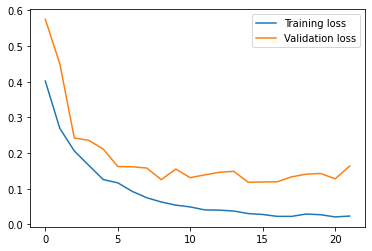

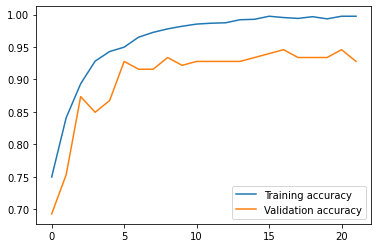

Fold 4 - Numero de epocas realizadas:  22
------------------------------------------------------------------------
Resultados obtenidos:
> Loss function: 0.15462319552898407
> Accuracy: 0.9267023404439291


In [ ]:
df_ensemble_3= validacionCruzada(model = ensemble_model, x_train = training_set, y_train = training_labels, num_folds = 3, model_name='Modelo Ensemble VGG19 ResNet101',verbose=1, show=True)

In [ ]:
#df_ensemble_3.to_csv('Ensemble3.csv')

In [ ]:
df_ensemble_3

,Modelo Ensemble VGG19 ResNet101
loss,0.154623
accuracy,0.926702


## Fine Tuning

A continuación se realiza el ajuste fino de algunos de los modelos. 
Se realizan las particiones de entrenamiento,test y validación usando los datos de entrenamiento para el proceso de validación experimental.

In [ ]:
# Partición entrenamiento-test
Xtrain, Xtest, Ytrain, Ytest = train_test_split(training_set, training_labels, test_size=0.2)
# Partición entrenamiento-validacion
Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(Xtrain, Ytrain, test_size=0.1)

Se declara la función la cual se encarga de realizar el ajuste fino

In [ ]:
def fine_tuning(model,Xtrain,Ytrain,Xvalid,Yvalid,Xtest,Ytest,model_name='Default'):
    batch_size = 32
    epochs = 40

    # Entrenamiento de la capa de salida
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

    model.fit(Xtrain,Ytrain,
            validation_data=(Xvalid,Yvalid),
            steps_per_epoch=len(Xtrain)/batch_size,
            epochs=epochs,
            callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)],
            validation_steps=len(Xvalid)/batch_size,
            verbose=1)

    #Descongelamos y ajustamos el resto de la red
    model.trainable = True
    epochs = 20
    batch_size = 16
    
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(1e-5), metrics=['accuracy'])
    
    # Entrenamiento
    mostrarEvolucion(model.fit(Xtrain,Ytrain,
            validation_data=(Xvalid,Yvalid),
            steps_per_epoch=len(Xtrain)/batch_size,
            epochs=epochs,
            callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)],
            validation_steps=len(Xvalid)/batch_size,
            verbose=1 ))
    
   # Validación
    score = model.evaluate(Xtest,Ytest,verbose=1)
    print('Accuracy:', score[1])
    print('Loss:', score[0])

    # Creamos el dataFrame 
    df = import_metric_pandas(model_name,score[0],score[1])

    return df

Epoch 1/40
55/55 [==============================] - 14s 154ms/step - loss: 0.8688 - accuracy: 0.7392 - val_loss: 0.7711 - val_accuracy: 0.8090
Epoch 2/40
55/55 [==============================] - 6s 116ms/step - loss: 0.4149 - accuracy: 0.8579 - val_loss: 1.4090 - val_accuracy: 0.6784
Epoch 3/40
55/55 [==============================] - 7s 120ms/step - loss: 0.2898 - accuracy: 0.9015 - val_loss: 0.4146 - val_accuracy: 0.8442
Epoch 4/40
55/55 [==============================] - 7s 122ms/step - loss: 0.1594 - accuracy: 0.9379 - val_loss: 0.2610 - val_accuracy: 0.8995
Epoch 5/40
55/55 [==============================] - 6s 117ms/step - loss: 0.1508 - accuracy: 0.9446 - val_loss: 0.3687 - val_accuracy: 0.8593
Epoch 6/40
55/55 [==============================] - 7s 117ms/step - loss: 0.1016 - accuracy: 0.9636 - val_loss: 0.3214 - val_accuracy: 0.8794
Epoch 7/40
55/55 [==============================] - 7s 121ms/step - loss: 0.0684 - accuracy: 0.9726 - val_loss: 0.2294 - val_accuracy: 0.8995
Epoch

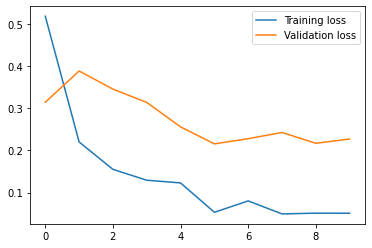

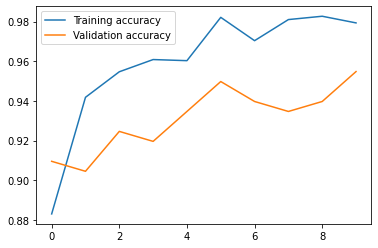

16/16 [==============================] - 2s 98ms/step - loss: 0.3690 - accuracy: 0.9095
Accuracy: 0.909456729888916
Loss: 0.36896371841430664


In [ ]:
modelo=modelo2()
df_ft_modelo2=fine_tuning(modelo,Xtrain,Ytrain,Xvalid,Yvalid,Xtest,Ytest,model_name='Modelo 2 FT')

In [ ]:
#df_ft_modelo2.to_csv('Modelo2_FT.csv')

In [ ]:
df_ft_modelo2

,Modelo 2 FT
loss,0.368964
accuracy,0.909457


Epoch 1/40
55/55 [==============================] - 15s 165ms/step - loss: 1.4263 - accuracy: 0.4471 - val_loss: 0.7391 - val_accuracy: 0.7085
Epoch 2/40
55/55 [==============================] - 6s 115ms/step - loss: 0.5765 - accuracy: 0.7812 - val_loss: 0.6591 - val_accuracy: 0.8442
Epoch 3/40
55/55 [==============================] - 6s 115ms/step - loss: 0.4170 - accuracy: 0.8450 - val_loss: 0.3905 - val_accuracy: 0.8543
Epoch 4/40
55/55 [==============================] - 6s 112ms/step - loss: 0.2933 - accuracy: 0.8926 - val_loss: 0.8568 - val_accuracy: 0.7588
Epoch 5/40
55/55 [==============================] - 6s 113ms/step - loss: 0.2611 - accuracy: 0.9049 - val_loss: 0.5339 - val_accuracy: 0.8241
Epoch 6/40
55/55 [==============================] - 6s 112ms/step - loss: 0.2384 - accuracy: 0.9088 - val_loss: 0.4469 - val_accuracy: 0.8593
Epoch 7/40
55/55 [==============================] - 6s 113ms/step - loss: 0.2287 - accuracy: 0.9194 - val_loss: 0.6052 - val_accuracy: 0.8291
Epoch

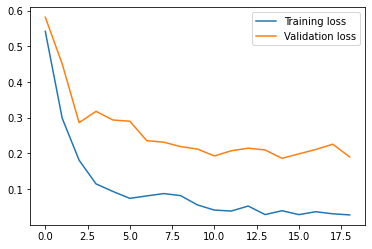

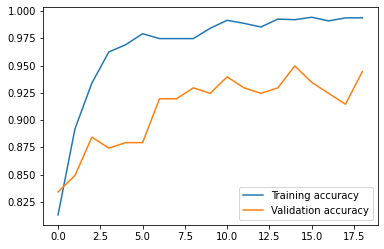

16/16 [==============================] - 2s 109ms/step - loss: 0.2430 - accuracy: 0.9175
Accuracy: 0.9175050258636475
Loss: 0.24297578632831573


In [ ]:
modelo=modelo_inception()
df_ft_inception=fine_tuning(modelo,Xtrain,Ytrain,Xvalid,Yvalid,Xtest,Ytest,model_name='Modelo Inception FT')

In [ ]:
#df_ft_inception.to_csv('ModeloInception_FT.csv')

In [ ]:
df_ft_inception

,Modelo Inception FT
loss,0.242976
accuracy,0.917505


Epoch 1/40
55/55 [==============================] - 73s 780ms/step - loss: 0.5992 - accuracy: 0.7812 - val_loss: 1.1116 - val_accuracy: 0.7236
Epoch 2/40
55/55 [==============================] - 28s 497ms/step - loss: 0.3498 - accuracy: 0.8870 - val_loss: 0.3793 - val_accuracy: 0.8543
Epoch 3/40
55/55 [==============================] - 29s 528ms/step - loss: 0.2474 - accuracy: 0.9323 - val_loss: 0.4031 - val_accuracy: 0.8643
Epoch 4/40
55/55 [==============================] - 28s 511ms/step - loss: 0.1859 - accuracy: 0.9524 - val_loss: 0.3251 - val_accuracy: 0.8794
Epoch 5/40
55/55 [==============================] - 28s 499ms/step - loss: 0.1652 - accuracy: 0.9474 - val_loss: 0.3767 - val_accuracy: 0.9095
Epoch 6/40
55/55 [==============================] - 29s 524ms/step - loss: 0.1113 - accuracy: 0.9670 - val_loss: 0.2261 - val_accuracy: 0.9196
Epoch 7/40
55/55 [==============================] - 31s 555ms/step - loss: 0.0979 - accuracy: 0.9731 - val_loss: 0.2441 - val_accuracy: 0.8844

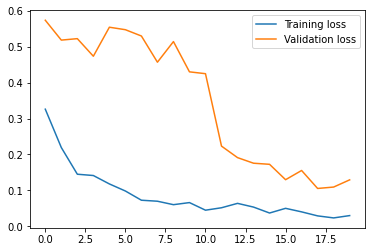

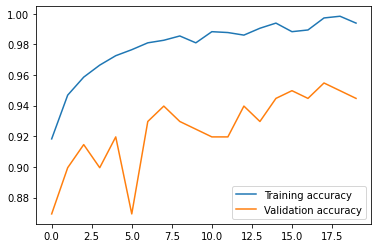

16/16 [==============================] - 11s 680ms/step - loss: 0.1399 - accuracy: 0.9618
Accuracy: 0.9617705941200256
Loss: 0.1399385780096054


In [ ]:
ensembled_models = [resnet101_model,vgg19_model,densenet121_model]
ensemble_model = ensemble(ensembled_models,model_input)
modelo=ensemble_model
df_ft_ensemble=fine_tuning(modelo,Xtrain,Ytrain,Xvalid,Yvalid,Xtest,Ytest,model_name='Modelo Ensemble FT')

In [ ]:
#df_ft_ensemble.to_csv('ModeloEnsemble_FT.csv')

In [ ]:
df_ft_ensemble

,Modelo Ensemble FT
loss,0.139939
accuracy,0.961771


# Evaluación en el conjunto de Test

Tras el análisis de los resultados expuesto en la memoria se procede a aplicar el conjunto de test a los modelos que mejores resultados han presentado en el proceso de validación experimental y en vista del análisis de los resultados expuesto en la memoria del proyecto.

Para ello, se usa la función __fit_evaluate__ detallada en el apartado de funciones auxiliares.

In [ ]:
batch_size = 32
epochs = 40
early = 7
opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)

### Modelo 2

Epoch 1/40
70/70 [==============================] - 30s 205ms/step - loss: 0.7428 - accuracy: 0.7637 - val_loss: 0.6837 - val_accuracy: 0.7912
Epoch 2/40
70/70 [==============================] - 9s 135ms/step - loss: 0.3183 - accuracy: 0.8912 - val_loss: 0.5791 - val_accuracy: 0.8554
Epoch 3/40
70/70 [==============================] - 9s 126ms/step - loss: 0.1974 - accuracy: 0.9302 - val_loss: 0.4867 - val_accuracy: 0.8353
Epoch 4/40
70/70 [==============================] - 9s 129ms/step - loss: 0.1338 - accuracy: 0.9485 - val_loss: 0.5582 - val_accuracy: 0.8675
Epoch 5/40
70/70 [==============================] - 9s 132ms/step - loss: 0.1115 - accuracy: 0.9588 - val_loss: 0.4507 - val_accuracy: 0.8795
Epoch 6/40
70/70 [==============================] - 9s 122ms/step - loss: 0.0756 - accuracy: 0.9722 - val_loss: 0.4600 - val_accuracy: 0.9036
Epoch 7/40
70/70 [==============================] - 9s 130ms/step - loss: 0.0482 - accuracy: 0.9843 - val_loss: 0.6260 - val_accuracy: 0.8594
Epoch

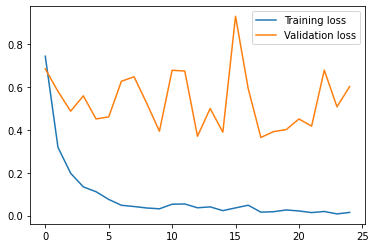

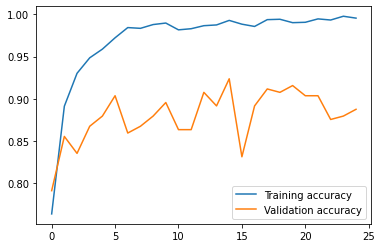

Numero de epocas realizadas:  25
------------------------------------------------------------------------
Resultados obtenidos:
> Loss function: 1.6304941177368164
> Accuracy: 0.7583892345428467


In [ ]:
# Ejecutamos el modelo
modelo = modelo2()
df_m2_test = fit_evaluate(modelo,'Modelo2 MC Test',training_set,training_labels,test_set,test_labels,verbose=1,show = True)

In [ ]:
# Guardamos en disco el dataFrame
#df_m2_test.to_csv('Test_Modelo2_MC.csv')

In [ ]:
# Imprimimos el dataframe
df_m2_test

,Modelo2 MC Test
loss,1.630494
accuracy,0.758389


### Modelo 4

Epoch 1/40
70/70 [==============================] - 20s 163ms/step - loss: 1.0636 - accuracy: 0.5877 - val_loss: 0.9430 - val_accuracy: 0.6506
Epoch 2/40
70/70 [==============================] - 9s 125ms/step - loss: 0.5096 - accuracy: 0.7847 - val_loss: 0.6934 - val_accuracy: 0.7108
Epoch 3/40
70/70 [==============================] - 9s 124ms/step - loss: 0.4093 - accuracy: 0.8348 - val_loss: 0.5783 - val_accuracy: 0.8193
Epoch 4/40
70/70 [==============================] - 9s 122ms/step - loss: 0.3332 - accuracy: 0.8662 - val_loss: 0.6286 - val_accuracy: 0.7791
Epoch 5/40
70/70 [==============================] - 9s 130ms/step - loss: 0.2880 - accuracy: 0.8868 - val_loss: 0.6342 - val_accuracy: 0.7711
Epoch 6/40
70/70 [==============================] - 9s 125ms/step - loss: 0.2635 - accuracy: 0.8881 - val_loss: 0.4995 - val_accuracy: 0.8353
Epoch 7/40
70/70 [==============================] - 9s 123ms/step - loss: 0.1992 - accuracy: 0.9257 - val_loss: 0.6196 - val_accuracy: 0.8032
Epoch

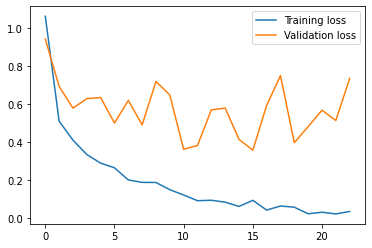

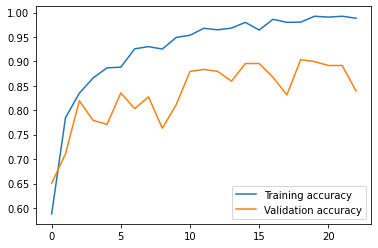

Numero de epocas realizadas:  23
------------------------------------------------------------------------
Resultados obtenidos:
> Loss function: 1.2970818281173706
> Accuracy: 0.7953020334243774


In [ ]:
# Ejecutamos el modelo
modelo = modelo_inception()
df_mIcp_test = fit_evaluate(modelo,'Modelo Inception MC test',training_set,training_labels,test_set,test_labels,verbose=1,show = True)

In [ ]:
# Guardamos en disco el dataFrame
#df_mIcp_test.to_csv('Test_Incep_MC.csv')

In [ ]:
# Imprimimos el dataframe
df_mIcp_test

,Modelo Inception MC test
loss,1.297082
accuracy,0.795302


## Modelo Ensemble

Epoch 1/40
70/70 [==============================] - 74s 755ms/step - loss: 0.7009 - accuracy: 0.7310 - val_loss: 1.4235 - val_accuracy: 0.5984
Epoch 2/40
70/70 [==============================] - 35s 501ms/step - loss: 0.4557 - accuracy: 0.8384 - val_loss: 0.5372 - val_accuracy: 0.7550
Epoch 3/40
70/70 [==============================] - 36s 513ms/step - loss: 0.3794 - accuracy: 0.8751 - val_loss: 0.4554 - val_accuracy: 0.8233
Epoch 4/40
70/70 [==============================] - 36s 510ms/step - loss: 0.3113 - accuracy: 0.9006 - val_loss: 0.3482 - val_accuracy: 0.8795
Epoch 5/40
70/70 [==============================] - 35s 499ms/step - loss: 0.2427 - accuracy: 0.9252 - val_loss: 0.3593 - val_accuracy: 0.8635
Epoch 6/40
70/70 [==============================] - 37s 528ms/step - loss: 0.2230 - accuracy: 0.9320 - val_loss: 0.3265 - val_accuracy: 0.9036
Epoch 7/40
70/70 [==============================] - 37s 535ms/step - loss: 0.1600 - accuracy: 0.9593 - val_loss: 0.3109 - val_accuracy: 0.8996

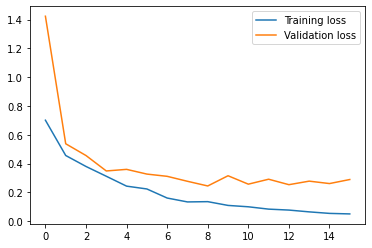

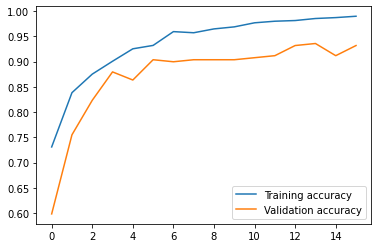

Numero de epocas realizadas:  16
------------------------------------------------------------------------
Resultados obtenidos:
> Loss function: 1.9063600301742554
> Accuracy: 0.718120813369751


In [ ]:
# Ejecutamos el modelo
ensembled_models = [resnet101_model,vgg19_model,densenet121_model]
ensemble_model = ensemble(ensembled_models,model_input)
modelo=ensemble_model
df_ensemble_test = fit_evaluate(modelo,'Modelo Ensemble MC test',training_set,training_labels,test_set,test_labels,verbose=1,show = True)

In [ ]:
# Guardamos en disco el dataFrame
#df_ensemble_test.to_csv('Test_Ensemble.csv')

In [ ]:
# Imprimimos el dataframe
df_ensemble_test

,Modelo Ensemble MC test
loss,1.906360
accuracy,0.718121


Epoch 1/40
70/70 [==============================] - 74s 667ms/step - loss: 0.5657 - accuracy: 0.7860 - val_loss: 1.2695 - val_accuracy: 0.6747
Epoch 2/40
70/70 [==============================] - 26s 378ms/step - loss: 0.2918 - accuracy: 0.8997 - val_loss: 0.4947 - val_accuracy: 0.8635
Epoch 3/40
70/70 [==============================] - 27s 391ms/step - loss: 0.1864 - accuracy: 0.9414 - val_loss: 0.3813 - val_accuracy: 0.8916
Epoch 4/40
70/70 [==============================] - 28s 398ms/step - loss: 0.1381 - accuracy: 0.9628 - val_loss: 0.3348 - val_accuracy: 0.8996
Epoch 5/40
70/70 [==============================] - 27s 388ms/step - loss: 0.1149 - accuracy: 0.9660 - val_loss: 0.3361 - val_accuracy: 0.8956
Epoch 6/40
70/70 [==============================] - 27s 392ms/step - loss: 0.0910 - accuracy: 0.9749 - val_loss: 0.3945 - val_accuracy: 0.9197
Epoch 7/40
70/70 [==============================] - 29s 408ms/step - loss: 0.0708 - accuracy: 0.9816 - val_loss: 0.2818 - val_accuracy: 0.9277

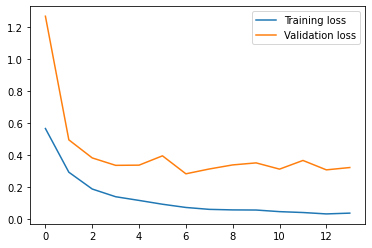

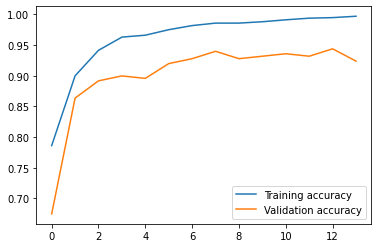

Numero de epocas realizadas:  14
------------------------------------------------------------------------
Resultados obtenidos:
> Loss function: 1.3514543771743774
> Accuracy: 0.755033552646637


In [ ]:
# Ejecutamos el modelo
ensembled_models = [inception_model,vgg19_model,densenet121_model]
ensemble_model = ensemble(ensembled_models,model_input)
modelo=ensemble_model
df_ensemble_test = fit_evaluate(modelo,'Modelo Ensemble MC test 2',training_set,training_labels,test_set,test_labels,verbose=1,show = True)

## Modelos con Fine Tuning

In [ ]:
# Partición entrenamiento-validacion
Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(training_set, training_labels, test_size=0.1)

Epoch 1/40
69/69 [==============================] - 31s 202ms/step - loss: 1.1278 - accuracy: 0.6097 - val_loss: 0.5225 - val_accuracy: 0.8032
Epoch 2/40
69/69 [==============================] - 8s 120ms/step - loss: 0.5777 - accuracy: 0.8115 - val_loss: 4.8452 - val_accuracy: 0.6386
Epoch 3/40
69/69 [==============================] - 9s 123ms/step - loss: 0.4181 - accuracy: 0.8384 - val_loss: 0.4245 - val_accuracy: 0.8474
Epoch 4/40
69/69 [==============================] - 9s 128ms/step - loss: 0.3168 - accuracy: 0.8850 - val_loss: 0.5464 - val_accuracy: 0.8675
Epoch 5/40
69/69 [==============================] - 9s 122ms/step - loss: 0.2238 - accuracy: 0.9096 - val_loss: 0.3284 - val_accuracy: 0.8554
Epoch 6/40
69/69 [==============================] - 8s 121ms/step - loss: 0.1901 - accuracy: 0.9306 - val_loss: 0.5151 - val_accuracy: 0.8193
Epoch 7/40
69/69 [==============================] - 8s 121ms/step - loss: 0.2073 - accuracy: 0.9239 - val_loss: 0.3726 - val_accuracy: 0.8996
Epoch

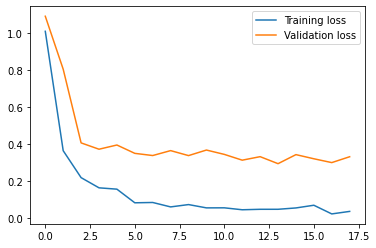

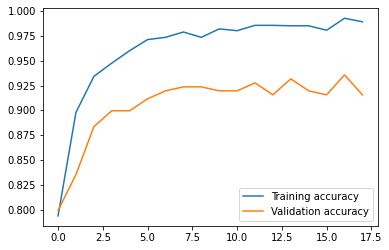

10/10 [==============================] - 1s 100ms/step - loss: 2.1226 - accuracy: 0.7282
Accuracy: 0.7281879186630249
Loss: 2.1226277351379395


In [ ]:
modelo=modelo_inception()
df_ft_inception_test=fine_tuning(modelo,Xtrain,Ytrain,Xvalid,Yvalid,test_set,test_labels,model_name='Modelo Inception FT test')

In [ ]:
# Guardamos en disco el dataFrame
#df_ft_inception_test.to_csv('Test_FT_Inception.csv')

In [ ]:
# Imprimimos el dataframe
df_ft_inception_test

,Modelo Inception FT test
loss,2.122628
accuracy,0.728188


Epoch 1/40
69/69 [==============================] - 82s 770ms/step - loss: 0.5740 - accuracy: 0.7865 - val_loss: 0.5708 - val_accuracy: 0.7871
Epoch 2/40
69/69 [==============================] - 34s 492ms/step - loss: 0.3297 - accuracy: 0.8939 - val_loss: 0.3708 - val_accuracy: 0.9116
Epoch 3/40
69/69 [==============================] - 35s 506ms/step - loss: 0.2413 - accuracy: 0.9293 - val_loss: 0.3507 - val_accuracy: 0.8956
Epoch 4/40
69/69 [==============================] - 35s 509ms/step - loss: 0.1877 - accuracy: 0.9432 - val_loss: 0.2629 - val_accuracy: 0.9157
Epoch 5/40
69/69 [==============================] - 36s 512ms/step - loss: 0.1535 - accuracy: 0.9620 - val_loss: 0.2339 - val_accuracy: 0.9237
Epoch 6/40
69/69 [==============================] - 35s 497ms/step - loss: 0.1200 - accuracy: 0.9637 - val_loss: 0.2346 - val_accuracy: 0.9478
Epoch 7/40
69/69 [==============================] - 36s 523ms/step - loss: 0.0989 - accuracy: 0.9776 - val_loss: 0.2096 - val_accuracy: 0.9598

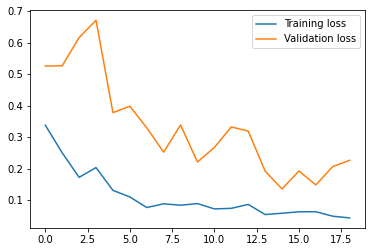

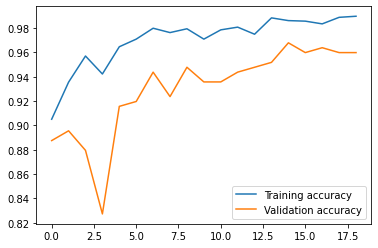

10/10 [==============================] - 4s 396ms/step - loss: 1.9240 - accuracy: 0.7483
Accuracy: 0.7483221292495728
Loss: 1.9240388870239258


In [ ]:
# Ejecutamos el modelo
ensembled_models = [resnet101_model,vgg19_model,densenet121_model]
ensemble_model = ensemble(ensembled_models,model_input)
modelo=ensemble_model
df_ft_ensemble_test=fine_tuning(modelo,Xtrain,Ytrain,Xvalid,Yvalid,test_set,test_labels,model_name='Modelo Ensemble FT test')

In [ ]:
# Guardamos en disco el dataFrame
#df_ft_ensemble_test.to_csv('Test_FT_Ensemble.csv')

In [ ]:
# Imprimimos el dataframe
df_ft_ensemble_test

,Modelo Ensemble FT test
loss,1.924039
accuracy,0.748322
